# Lectura de los datos
Simplemente realizamos la lectura de los datos de la base de datos MongoDB con las credenciales utilizadas en el script `db_insert.py`

In [6]:
import pandas as pd
from pymongo import MongoClient

# Read all the data and store it into a dataframe
myclient = MongoClient("mongodb://localhost:27017")
db = myclient["robin"]
collection = db["testPythonDB"]
df_products = pd.DataFrame(list(collection.find({})))

# Preparacion de los datos
Nos quedamos con los datos que necesitamos y que vamos a utilizar para en el siguiente paso entrenar nuestros modelos.
Este es el paso mas largo y uno de los mas importantes. Recordar siempre la regla GIGO (Garbage In - Garbage Out), es decir, por muy bueno que sea nuestro modelo, si lo entrenamos con basura, sus predicciones seran una basura.

In [7]:
df_products.head(5)

,_id,brandName,categoryCode,categoryName,marketplaceId,name,marketplaceName
0,6047914b6a3b4a0037a5b2e9,BURGER KING,10007596,Servicios de Alimentos y Bebidas,d28Pmf7Hgd3PE5W5x,menu familiar,BURGER KING
1,604a12f873915b00362975b7,SAMSUNG,10001400,Televisiones,DdZpbfXnRFsyqmCNh,Televisor Samsung 65'',AMAZON
2,604a135873915b00362975ba,NO IDENTIFICADA,10000356,Productos para el cuidado de la piel/hidratación,GT3mjN63Pi7QyR9WS,Crema hidratante facial,MIFARMA
3,604a135873915b00362975bb,NO IDENTIFICADA,10005839,Centro de Cuidado Bucal - Cepillo/Limpiador/Al...,GT3mjN63Pi7QyR9WS,cepillo de dientes electrico,MIFARMA
4,604b3f6e13515e00410166aa,BURGER KING,10007596,Servicios de Alimentos y Bebidas,d28Pmf7Hgd3PE5W5x,menu familiar,BURGER KING


In [9]:
import matplotlib.pyplot as plt

# Solo necesitamos dos columnas: name = descripcion y brandName = etiqueta
keep_columns = ["name", "categoryCode", "categoryName"]
df_products = df_products[keep_columns]


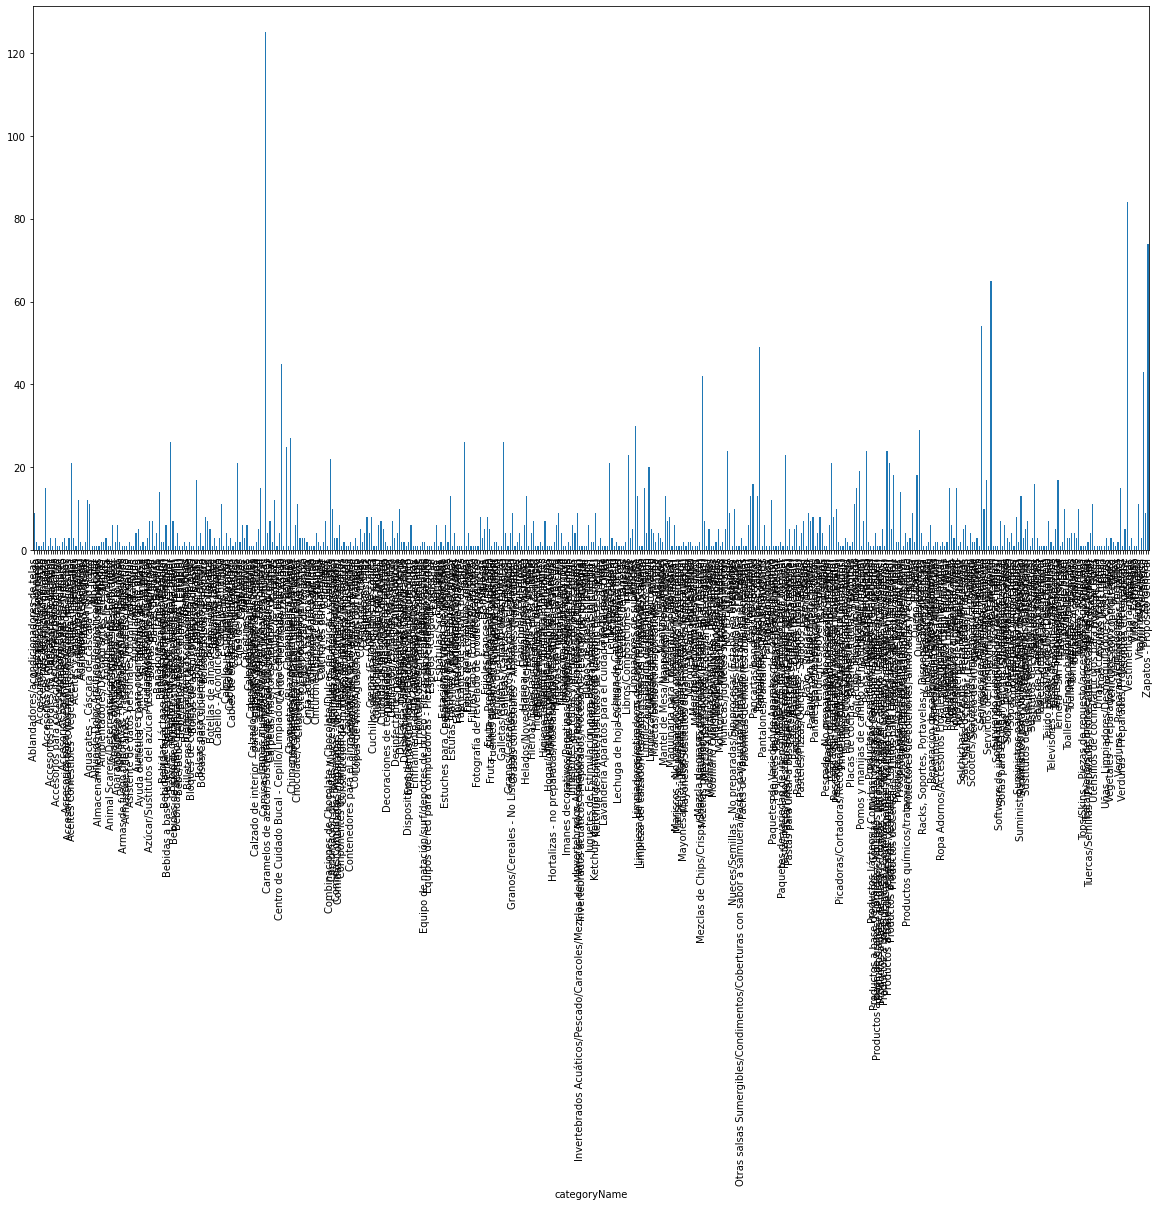

In [12]:
# len(df_products.categoryName.unique()) -> 483
# Vemos cuantos productos hay por categoria, al haber muchas categorias (483) no se vera muy bien
fig = plt.figure(figsize=(20,10))
df_products.groupby('categoryName').name.count().plot.bar(ylim=0)
plt.show()

Como habiamos comentado, la visualizacion no es la mejor, pero nos da una idea de lo poco balanceadas que estan las clases. Es decir, hay muchisimos items de unas pocas categorias mientras que de otras hay muy pocos o incluso solo una. Con estos problemas, suele costar utilizar algoritmos mas estandar dado que no lo tienen en cuenta y acaban teniendo un sesgo demasiado grande hacia las clases mayoritarias. Sin embargo, en nuestro caso igual no es tan problematico acabar prediciendo mas veces hacia las marcas mas representadas en el dataset dado que puede ser una buena representacion de la realidad.

A continuacion utilizaremos TF-IDF para crear un vector para cada descripcion de item. Esta tecnica es muy utilizada dado que depende de dos metricas: el número de veces que una palabra aparece en un dato y la frecuencia inversa de la palabra en un conjunto de datos, dado asi una metrica relativa al dataset que estamos utilizando.

In [22]:
# from io import StringIO
df_products = df_products[pd.notnull(df_products['name'])]
# df_products['brandId'] = df_products['brandName'].factorize()[0]
# brand_id_df = df_products[['brandName', 'brandId']].drop_duplicates().sort_values('brandId')
# brand_to_id = dict(brand_id_df.values)
# id_to_brand = dict(brand_id_df[['brandId', 'brandName']].values)

from sklearn.feature_extraction.text import TfidfVectorizer
# Leemos las stopwords en español dado que no estan definidas por sklearn
import unidecode
with open("stop-words-spanish.txt") as f:
    stopwords = f.readlines()
stopwords = [unidecode.unidecode(x.strip()) for x in stopwords] 

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words=stopwords)
features = tfidf.fit_transform(df_products.name).toarray()
labels = df_products['categoryCode']

In [24]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for category, categoryCode in df_products[["categoryName", "categoryCode"]].drop_duplicates().values:
  features_chi2 = chi2(features, labels == categoryCode)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print(f"# '{category}':")
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))


# 'Servicios de Alimentos y Bebidas':
  . Most correlated unigrams:
. restaurante
. mcdonald
  . Most correlated bigrams:
. de cocina
. just eat
# 'Televisiones':
  . Most correlated unigrams:
. smart
. 65
  . Most correlated bigrams:
. bosque verde
. hacendado paquete
# 'Productos para el cuidado de la piel/hidratación':
  . Most correlated unigrams:
. facial
. hidratante
  . Most correlated bigrams:
. 50 ml
. 100 ml
# 'Centro de Cuidado Bucal - Cepillo/Limpiador/Almacenamiento (eléctrico)':
  . Most correlated unigrams:
. cepillo
. dientes
  . Most correlated bigrams:
. cepillo de
. de dientes
# 'Software de computadora (no de juegos)':
  . Most correlated unigrams:
. 10
. pro
  . Most correlated bigrams:
. bosque verde
. hacendado paquete
# 'Servicios de Entretenimiento':
  . Most correlated unigrams:
. cine
. entradas
  . Most correlated bigrams:
. hacendado paquete
. de 12
# 'Desinfectantes para manos / Antisépticos':
  . Most correlated unigrams:
. manos
. 10
  . Most correlated 

Podemos ver que algunos valores tienen mucho sentido mientras que otros solamente aparecen dado el desbalance de los datos. Procedere con los modelos dado que esto implicaria un estudio mucho mas detallado y exhaustivo de los datos y no tengo tiempo para ello.

# Modelos predictivos

Una vez ya tenemos los datos, el siguiente paso es entrenar un modelo con ellos. En este caso, realizaremos el entrenamiento de 4 modelos de clasificacion distintos: RandomForest, MultinomialNB (Naive Bayes), LinearSVC y LogisticRegression.

Utilizaremos la tecnica de validacion cruzada con todos ellos para ver cual de los cuatro nos da mejores resultados

/home/vscode/.local/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/vscode/.local/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/vscode/.local/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/vscode/.local/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


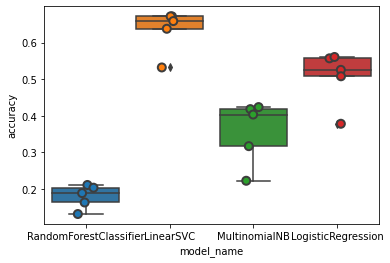

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()


In [27]:
# Por ultimo comparamos la precision media de estos modelos
cv_df.groupby('model_name').accuracy.mean()


model_name
LinearSVC                 0.634878
LogisticRegression        0.506254
MultinomialNB             0.357237
RandomForestClassifier    0.179739
Name: accuracy, dtype: float64

Podemos ver que aunque todos los resultados son algo decepcionantes, el que mejor se comporta es la maquina de soporte LinearSVC.
Ahora realizaremos una evaluacion de este modelo.

In [38]:
from sklearn.model_selection import train_test_split

model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df_products.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn import metrics
# Como tenemos un problema con el balance, no tenemos el mismo numero de clases
# en el dataset que en la prediccion + test
categoryCodes = np.unique(np.append(y_pred, y_test.values))
categories = df_products[np.isin(df_products['categoryCode'].values, categoryCodes)].categoryName.unique()

print(metrics.classification_report(y_test, y_pred, target_names=categories))

                                                                                                                          precision    recall  f1-score   support

                                                                                        Servicios de Alimentos y Bebidas       0.00      0.00      0.00         1
                                                                                                            Televisiones       0.00      0.00      0.00         2
                                                                        Productos para el cuidado de la piel/hidratación       1.00      1.00      1.00         4
                                                  Centro de Cuidado Bucal - Cepillo/Limpiador/Almacenamiento (eléctrico)       1.00      1.00      1.00         2
                                                                                            Servicios de Entretenimiento       0.86      0.86      0.86         7
                           

Aunque no sea lo unico determinante podemos ver que en las categorias en las que tenemos un soporte mayor, suele ser en las que mas acertamos.